In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import itertools
from sklearn.metrics import mean_squared_error,r2_score
import warnings
#忽略警告输出
warnings.filterwarnings("ignore")
#用来正常显示中文标签
plt.rcParams["font.sans-serif"]=["SimHei"]
#用来显示负号
plt.rcParams["axes.unicode_minus"]=False
#在jupyter中显示figure
%matplotlib inline

In [2]:
#导入数据
data= pd.read_csv('johns.csv',parse_dates=["time"],index_col='time')#读取
data

,Unnamed: 0,value
time,,
1960-03-01,1,0.71
1960-06-01,2,0.63
1960-09-01,3,0.85
1960-12-01,4,0.44
1961-03-01,5,0.61
...,...,...
1979-12-01,80,9.99
1980-03-01,81,16.20
1980-06-01,82,14.67


No handles with labels found to put in legend.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


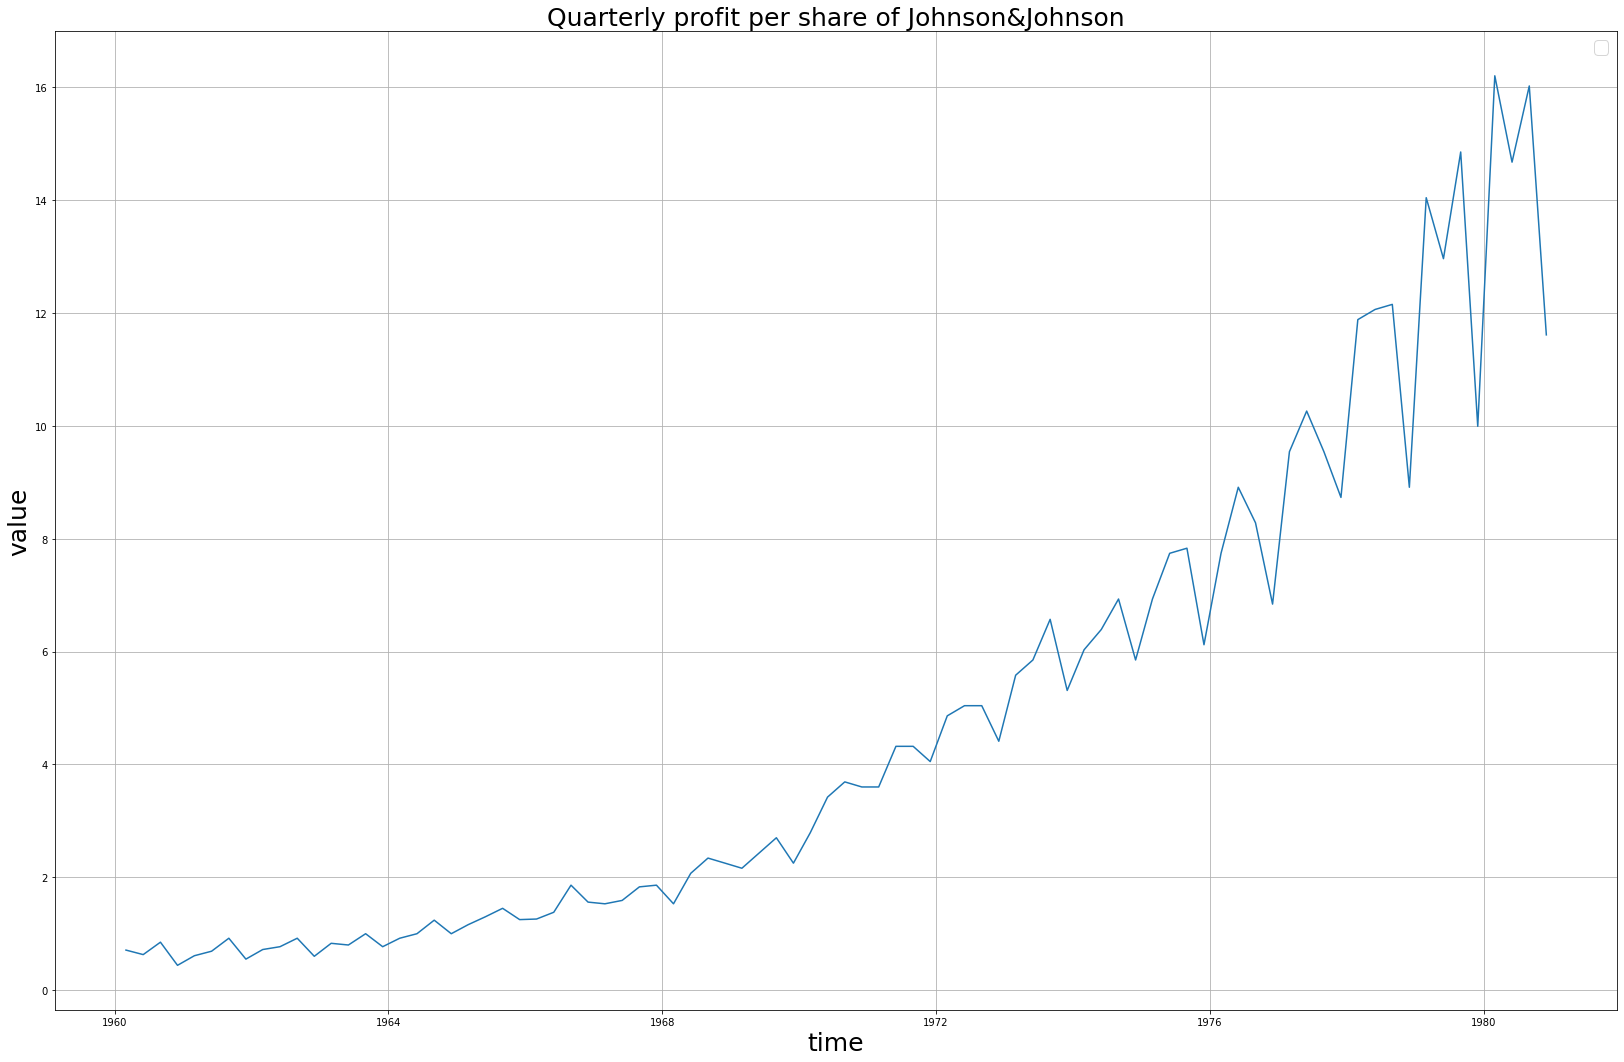

In [3]:
#绘制利润大图
keys1=data.keys()
fig,ax=plt.subplots(figsize=(28,18))
plt.plot(data['value'])
plt.title('Quarterly profit per share of Johnson&Johnson',fontsize=25)
ax.set_xlabel("time",fontsize=25)
ax.set_ylabel("value",fontsize=25)
ax.legend(loc="best",fontsize=18)
ax.grid()

In [4]:
NGE=data["value"]
NGE.head()

time
1960-03-01    0.71
1960-06-01    0.63
1960-09-01    0.85
1960-12-01    0.44
1961-03-01    0.61
Name: value, dtype: float64

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


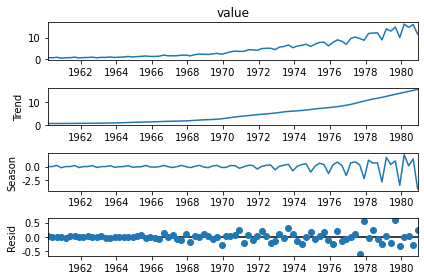

In [5]:
decomposition=tsa.STL(NGE).fit()
decomposition.plot()
#趋势效应
trend=decomposition.trend
#季节效应
seasonal=decomposition.seasonal
#随机效应
residual=decomposition.resid

In [6]:
#利用ADF检查平稳性
def test_stationarity(timeseries,alpha=1e-3):
    datatest=tsa.adfuller(timeseries,autolag="AIC")
    dfoutput=pd.Series(datatest[0:4],index=["Test Statistic","p-value","#Lags used","Number of Observations Used"])
    for key,value in datatest[4].items():
        dfoutput["Critical Value(%s)"%key]=value
        
        print(dfoutput)
        critical_value=datatest[4]["5%"]
        test_statistic=datatest[0]
        pvalue=datatest[1]
        if pvalue<alpha and test_statistic<critical_value:#null hypothesis:x is non stationary
            print("X is stationary")
            return True
        else:
            print("X is not stationary")
            return False

In [7]:
test_stationarity(NGE)

Test Statistic                  2.742017
p-value                         1.000000
#Lags used                     11.000000
Number of Observations Used    72.000000
Critical Value(1%)             -3.524624
dtype: float64
X is not stationary


False

In [8]:
#平稳化操作
#一阶差分
nge_difference=NGE.diff(1)
#12步差分
nge_seasonal=nge_difference.diff(12)
test_stationarity(nge_seasonal.dropna())

Test Statistic                 -3.207938
p-value                         0.019530
#Lags used                      4.000000
Number of Observations Used    66.000000
Critical Value(1%)             -3.533560
dtype: float64
X is not stationary


False

In [9]:
#白噪声检验
def test_white_noise(data):
    return sm.stats.acorr_ljungbox(data.dropna(),return_df=True)

In [10]:
test_white_noise(NGE)

,lb_stat,lb_pvalue
1,74.486740,6.104693e-18
2,143.996709,5.389048e-32
3,205.858744,2.286446e-44
4,267.181739,1.291928e-56
5,320.528712,3.852584e-67
6,368.220282,1.887230e-76
7,410.969252,1.058822e-84
8,451.669017,1.623008e-92
9,487.314303,2.988023e-99
10,518.384064,5.191993e-105


<function matplotlib.pyplot.show(close=None, block=None)>

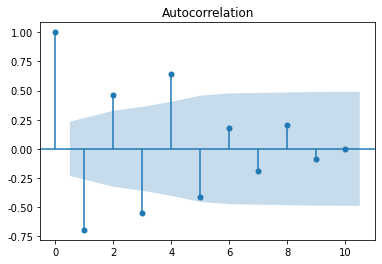

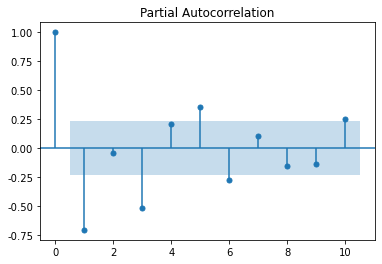

In [11]:
#绘制ACF，PACF图
fig=plot_acf(nge_seasonal.dropna(),lags=10)
fig=plot_pacf(nge_seasonal.dropna(),lags=10)
plt.show

In [12]:
#网格搜索pdq、PDQ
def grid_search(data):
    p=q=range(0,3)
    s=[12]
    d=[1]
    PDQs=list(itertools.product(p,d,q,s))
    pdq=list(itertools.product(p,d,q))
    params=[]
    seasonal_params=[]
    results=[]
    grid=pd.DataFrame()
    
    for param in pdq:
        for seasonal_param in PDQs:
            mod=tsa.SARIMAX(data,order=param,seasonal_order=seasonal_param,enforce_stationarity=False,enforce_invertibility=False)
            result=mod.fit()
            print("ARIMA{}X{}-AIC:{}".format(param,seasonal_param,result.aic))
            params.append(param)
            seasonal_params.append(seasonal_param)
            results.append(result.aic)
            
    grid["pdq"]=params
    grid["PDQs"]=seasonal_params
    grid["aic"]=results
    print(grid[grid["aic"]==grid["aic"].min()])

In [13]:
grid_search(NGE)

ARIMA(0, 1, 0)X(0, 1, 0, 12)-AIC:221.05530803862288
ARIMA(0, 1, 0)X(0, 1, 1, 12)-AIC:196.28735507735155
ARIMA(0, 1, 0)X(0, 1, 2, 12)-AIC:160.80766292517478
ARIMA(0, 1, 0)X(1, 1, 0, 12)-AIC:198.53152374927924
ARIMA(0, 1, 0)X(1, 1, 1, 12)-AIC:197.54067422474765
ARIMA(0, 1, 0)X(1, 1, 2, 12)-AIC:154.60046673509032
ARIMA(0, 1, 0)X(2, 1, 0, 12)-AIC:131.54974169997666
ARIMA(0, 1, 0)X(2, 1, 1, 12)-AIC:133.52719673130116
ARIMA(0, 1, 0)X(2, 1, 2, 12)-AIC:127.84232373124804
ARIMA(0, 1, 1)X(0, 1, 0, 12)-AIC:177.55770133092554
ARIMA(0, 1, 1)X(0, 1, 1, 12)-AIC:159.54426586184783
ARIMA(0, 1, 1)X(0, 1, 2, 12)-AIC:131.5212939302528
ARIMA(0, 1, 1)X(1, 1, 0, 12)-AIC:163.2562714682523
ARIMA(0, 1, 1)X(1, 1, 1, 12)-AIC:158.8755261782941
ARIMA(0, 1, 1)X(1, 1, 2, 12)-AIC:123.872981435711
ARIMA(0, 1, 1)X(2, 1, 0, 12)-AIC:119.12979216644126
ARIMA(0, 1, 1)X(2, 1, 1, 12)-AIC:120.5976902584072
ARIMA(0, 1, 1)X(2, 1, 2, 12)-AIC:115.03902345441539
ARIMA(0, 1, 2)X(0, 1, 0, 12)-AIC:155.58639949154386
ARIMA(0, 1, 2)X(0,

In [14]:
#建立模型
mod=tsa.SARIMAX(NGE,order=(1,1,2),seasonal_order=(2,1,2,12))
results=mod.fit()

In [15]:
test_white_noise(results.resid)

,lb_stat,lb_pvalue
1,0.181873,6.697687e-01
2,5.169205,7.542606e-02
3,5.244758,1.547274e-01
4,28.535134,9.715031e-06
5,30.815901,1.018476e-05
6,34.820395,4.668891e-06
7,35.006745,1.115183e-05
8,42.584124,1.051880e-06
9,43.040788,2.118763e-06
10,46.589889,1.121063e-06


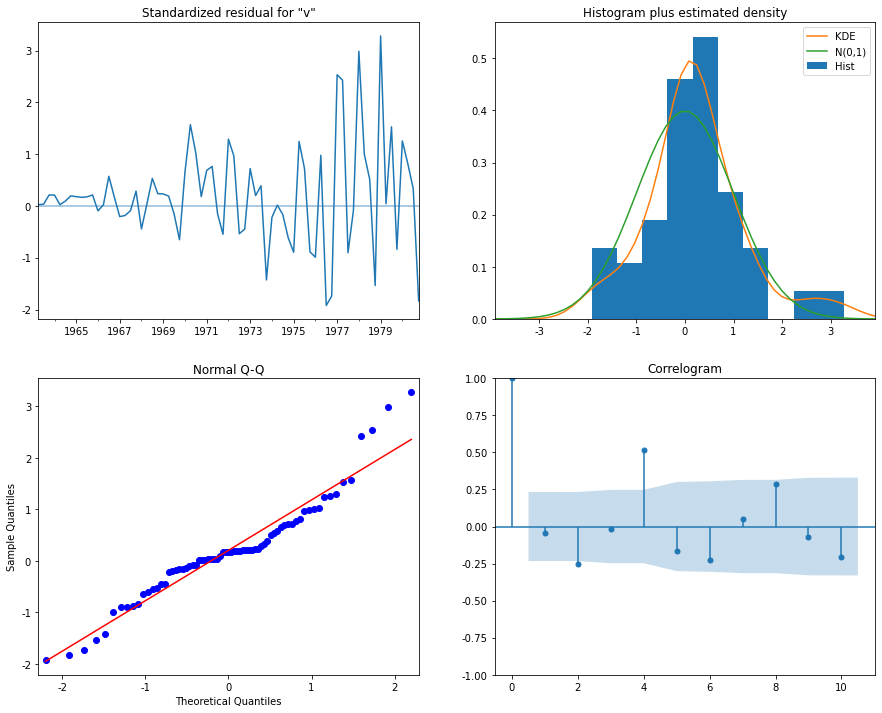

In [16]:
fig_result=results.plot_diagnostics(figsize=(15,12))

In [17]:
#预测
def get_prediction(data,results,start,dynamic=False):
    pred=results.get_prediction(start=start,dynamic=dynamic,full_results=True)
    pred_ci=pred.conf_int()
    forecast=pred.predicted_mean
    truth=data[start:]
    pred_concat=pd.concat([truth,forecast,pred_ci],axis=1)
    pred_concat.columns=["Original value","Estimate","lower limit","upper limit"]
    print("MSE:{}".format(mean_squared_error(truth,forecast)))
    print("RMSE:{}".format(np.sqrt(mean_squared_error(truth,forecast))))
    return pred_concat

MSE:0.7901705202270021
RMSE:0.8889153616779283


<AxesSubplot:>

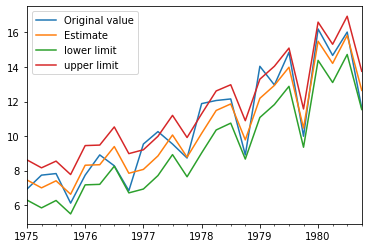

In [18]:
pred=get_prediction(NGE,results,"1975-03-01")
pred.plot()

MSE:2.2164483430137696
RMSE:1.4887741074500758


<AxesSubplot:>

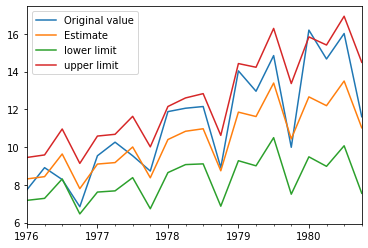

In [19]:
pred=get_prediction(NGE,results,"1976-03-01",dynamic=True)
pred.plot()

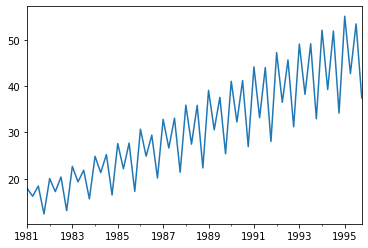

In [20]:
forecast=results.get_forecast(steps=60)
fig=forecast.predicted_mean.plot()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


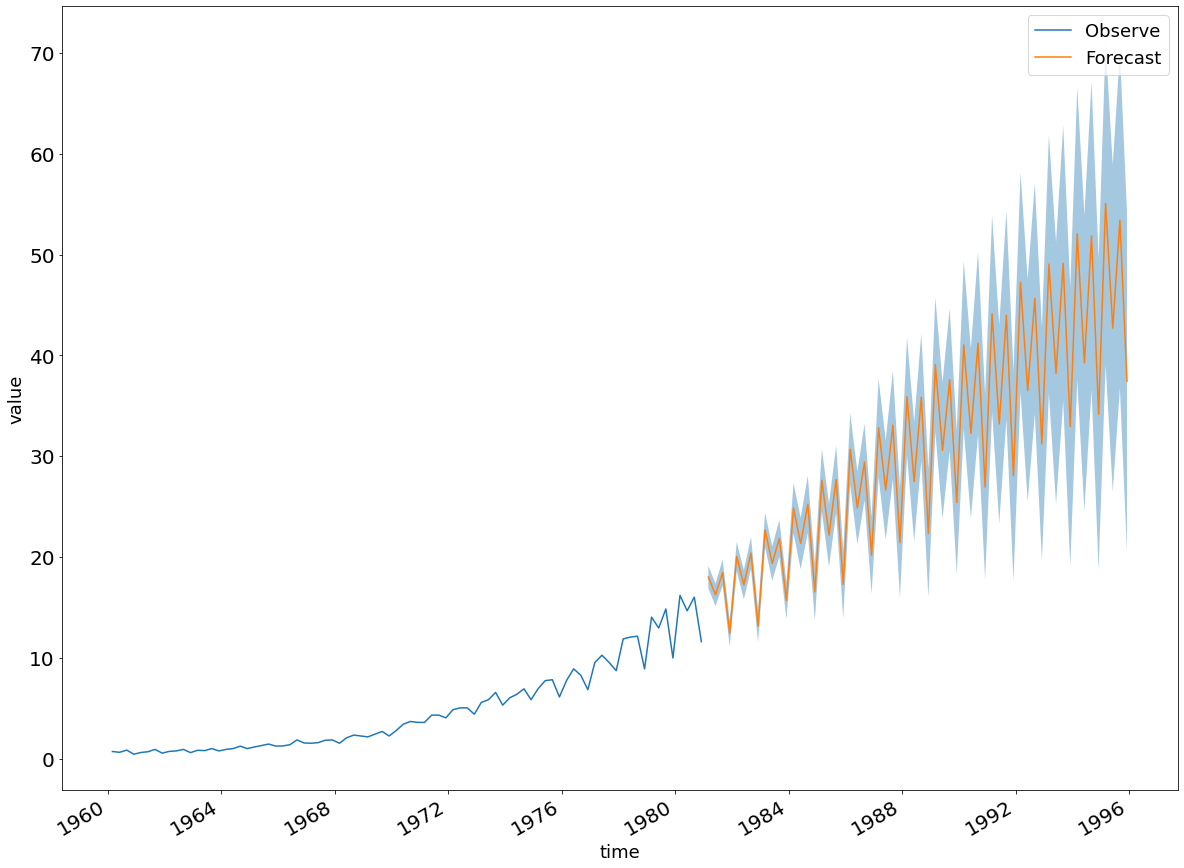

In [21]:
#展示最终预测
fig,ax=plt.subplots(figsize=(20,16))
ax.plot(NGE,label="Observe")
forecast.predicted_mean.plot(ax=ax,label="Forecast")
ax.fill_between(forecast.conf_int().index,forecast.conf_int().iloc[:,0],forecast.conf_int().iloc[:,1],alpha=0.4)
ax.set_xlabel("time",fontsize=18)
ax.set_ylabel("value",fontsize=18)
ax.legend(loc="best",fontsize=18)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

In [22]:
#第二种模型：ARIMA模型部分
import statsmodels.tsa.arima_model as smtsa
data1_df=data.copy()
aicVal1=[]
for p in range(1,3):
    for d in range(1,3):
        for q in range(1,3):
            try:
                arima_obj = smtsa.ARIMA(data1_df.value.tolist(),order=(p,d,q))\
                .fit(maxlag = 30,method='mle',trend='nc')
                aicVal1.append([p,d,q,arima_obj.aic])
            except Exception as e:
                print(e)

The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.


In [23]:
aicVal1

[[1, 1, 1, 262.7416488615295],
 [1, 1, 2, 248.87187470966973],
 [2, 1, 1, 264.7195112274502],
 [2, 1, 2, 249.96176658043638]]

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                   83
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -121.084
Method:                       css-mle   S.D. of innovations              0.942
Date:                Wed, 26 May 2021   AIC                            252.169
Time:                        12:17:22   BIC                            264.263
Sample:                    06-01-1960   HQIC                           257.028
                         - 12-01-1980                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1661        nan        nan        nan         nan         nan
ar.L1.D.value    -1.0000        nan        nan        nan         nan         nan
ma.L1.D.value     0.2400      0.076     

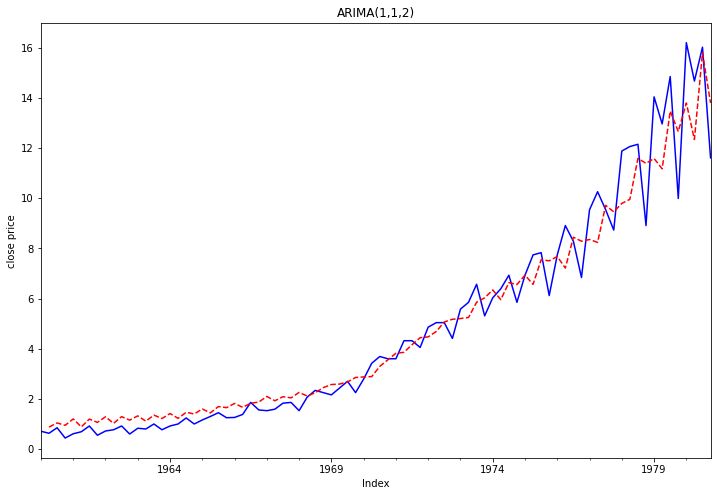

In [24]:
#使用ARIMA模型进行分析和预测
model1 = smtsa.ARIMA(data['value'],order = (1,1,2))
model1_fit = model1.fit(disp=0)
print(model1_fit.summary())

data['ARIMA'] = model1_fit.predict(typ='levels')
f,axarr = plt.subplots(1,sharex = True)
f.set_size_inches(12,8)
data['value'].plot(color = 'b',linestyle = '-',ax = axarr)
data['ARIMA'].plot(color = 'r',linestyle = '--',ax = axarr)
axarr.set_title('ARIMA(1,1,2)')
plt.xlabel('Index')
plt.ylabel('close price')
plt.show()

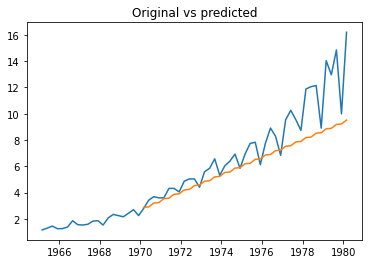

In [25]:
#预测
output = model1_fit.predict('19700301','19800301',dynamic=True,typ='levels')
#print(output)
#可视化预测结果
data1_forcast = pd.concat([data.value['19650301':'19800301'],output],axis=1,keys=['original','predicted'])
plt.figure()
plt.plot(data1_forcast)
plt.title('Original vs predicted')
plt.savefig('./data.pred.png',format='png')
plt.show()

In [33]:
#第三种模型：ARMA模型部分            
import statsmodels.tsa.arima_model as smtsa
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
data2_df=data.copy()
aicVal2=[]
for ari in range(1,3):
    for maj in range(1,2):
        try:
            arma_obj = smtsa.ARMA(data2_df.value.tolist(),order=(ari,maj))\
            .fit(maxlag = 30,method='mle',trend='nc')
            aicVal2.append([ari,maj,arma_obj.aic])
        except Exception as e:
            print(e)

The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.


In [34]:
aicVal2

[[1, 1, 274.74934350148084]]

                              ARMA Model Results                              
Dep. Variable:                  value   No. Observations:                   84
Model:                     ARMA(1, 1)   Log Likelihood                -139.517
Method:                       css-mle   S.D. of innovations              1.166
Date:                Wed, 26 May 2021   AIC                            287.034
Time:                        12:26:10   BIC                            296.757
Sample:                    03-01-1960   HQIC                           290.943
                         - 12-01-1980                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1575.0990      0.001   1.39e+06      0.000    1575.097    1575.101
ar.L1.value     1.0000        nan        nan        nan         nan         nan
ma.L1.value    -0.5733      0.062     -9.238    

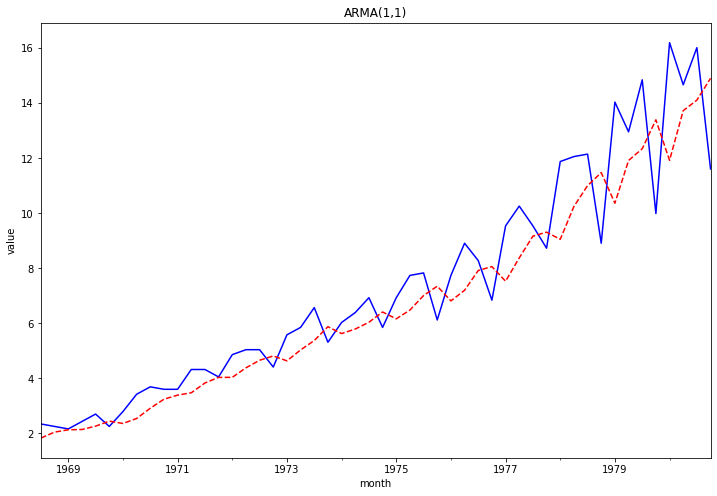

In [36]:
#使用ARMA模型进行分析和预测
model2 = smtsa.ARMA(data['value'],order = (1,1))
model2_fit = model2.fit(disp=0)
print(model2_fit.summary())

data2_df['ARMA'] = arma_obj_fin.predict()
f, axarr = plt.subplots(1,sharex=True)
f.set_size_inches(12,8)
data2_df['value'].iloc[len(data2_df)-50:]\
.plot(color='b',linestyle='-',ax=axarr)
data2_df['ARMA'].iloc[len(data2_df)-50:]\
.plot(color='r',linestyle='--',ax=axarr)
axarr.set_title('ARMA(1,1)')
plt.xlabel('month')
plt.ylabel('value')
plt.show()